#### **Scene Splitting**

In [ ]:
!pip install opencv-python

In [64]:
!pip install scenedetect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 21.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [33]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [111]:
import pandas as pd
import numpy as np
import cv2
import torch

from scenedetect import detect, AdaptiveDetector
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import math
import os

from utils.datasets import StronglyLabelledDataset

**Loading video from dataset**

In [2]:
dataset = StronglyLabelledDataset()

In [95]:
video, audio, labels_df, info = dataset[22200]

print(video.shape)
print(info)

torch.Size([223, 3, 224, 224])
{'video_fps': 23.788, 'audio_fps': 44100}


Saving locally and displaying

In [96]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

# Adjust the normalization of the video to match 0-255 scale
video = video * std + mean  # Denormalize
video = video.clamp(0, 1)  # Clamp to the range [0, 1]
video = video.permute(0, 2, 3, 1)  # Change to [frames, height, width, channels]

# Scale to 0-255 and convert to uint8
video_tensor = (video * 255).numpy().astype(np.uint8)

# Writing to a video file using OpenCV
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_video.mp4', fourcc, video_fps, (224, 224))
for i in range(video_tensor.shape[0]):
    out.write(video_tensor[i])
out.release()

In [97]:
from moviepy.editor import VideoFileClip
from IPython.display import display

# Load your video file
clip = VideoFileClip('output_video.mp4')

# Display the video
display(clip.ipython_display(width=480, autoplay=1, loop=1, maxduration=120))

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


**Scene detection with PySceneDetection**

In [99]:
video_local_path = "output_video.mp4"

In [100]:
content_list = detect(video_local_path, AdaptiveDetector())

In [101]:
content_list

[(00:00:00.000 [frame=0, fps=29.970], 00:00:04.638 [frame=139, fps=29.970]),
 (00:00:04.638 [frame=139, fps=29.970], 00:00:05.339 [frame=160, fps=29.970]),
 (00:00:05.339 [frame=160, fps=29.970], 00:00:07.107 [frame=213, fps=29.970]),
 (00:00:07.107 [frame=213, fps=29.970], 00:00:07.441 [frame=223, fps=29.970])]

In [109]:
## extract scenes
first_frame_indexes = {}
if len(content_list)>0:
    for i in range(len(content_list)):
        frame_num = (content_list[i][1] - content_list[i][0]).frame_num
        scene_first_frame_index = frame_num // 2 + content_list[i][0].frame_num
        first_frame_indexes[str(i)] = scene_first_frame_index
else:
    print('No multiple scenes detected')

In [110]:
first_frame_indexes

{'0': 69, '1': 149, '2': 186, '3': 218}

**Extract first scene**

In [106]:
frame_num = (content_list[0][1] - content_list[0][0]).frame_num
first_scene_frame_index = frame_num // 2 + content_list[0][0].frame_num

In [103]:
video = cv2.VideoCapture(video_local_path)

video.set(cv2.CAP_PROP_POS_FRAMES, first_scene_frame_index)
_, first_scene_frame = video.read()

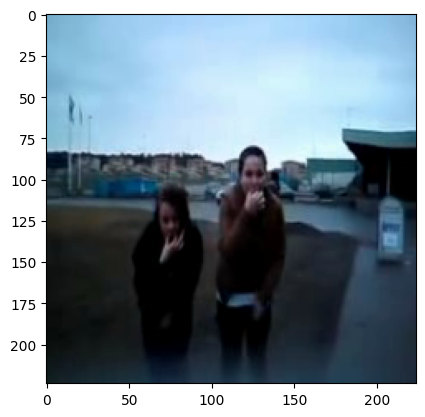

In [104]:
plt.imshow(first_scene_frame)